# Fokker-Planck approach
In this notebook we apply pushers to FokkerPlanck and Boltzmann-MonteCarlo to reproduce results from the paper by Niel2018 et al
https://journals.aps.org/pre/abstract/10.1103/PhysRevE.97.043209

$$\mathrm{d} \gamma = - S(\chi) \mathrm{d}t + \sqrt{R(\chi,\gamma)} \mathrm{d}W$$
with $\chi = 10^{-3} \gamma[1800] B[2.5kT] $

Data in dots was retrieved with WebPlotDIgitizer

OSIRIS-QED solves the Boltzmann / Rate equation with a Monte-Carlo routine (expect some differences with the FP pusher for higher chi values)

In [1]:
import pusherFP
from pusherFP import *
import glob as glob
import h5py
import json

In [2]:
# omega_p
elementary_charge/electron_mass/1800 * 2.5e3 * (1e-3/(1e-3))*1e-11

2.442805570516893

In [3]:
# initial conditions: Niel2018 page 17/27
g0 = 1800 #[] average energy
s0 = 90 #[] spread

# sampling
Nsmpl = int(5e3); #[] number of particles
tdim = 1000 #[]
nbins = 80 #[] number of bins in histograms
print("#particles =", Nsmpl, ", #timesteps =",tdim)

chi3t3y, chi3t3x, chi3t2y, chi3t2x, chi3t1y, chi3t1x, chi3mom1, chi3mom2 = pushFP(1e-3, Nsmpl, tdim, nbins, g0, s0)
chi2t3y, chi2t3x, chi2t2y, chi2t2x, chi2t1y, chi2t1x, chi2mom1, chi2mom2 = pushFP(1e-2, Nsmpl, tdim, nbins, g0, s0)
chi1t3y, chi1t3x, chi1t2y, chi1t2x, chi1t1y, chi1t1x, chi1mom1, chi1mom2 = pushFP(1e-1, Nsmpl, tdim, nbins, g0, s0)
chi0t3y, chi0t3x, chi0t2y, chi0t2x, chi0t1y, chi0t1x, chi0mom1, chi0mom2 = pushFP(1e0, Nsmpl, tdim, nbins, g0, s0)

#particles = 5000 , #timesteps = 1000
chi0 = 0.001
dt = 0.02


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1394.40it/s]


chi0 = 0.01
dt = 0.02


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1426.69it/s]


chi0 = 0.1
dt = 0.005


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1359.95it/s]


chi0 = 1.0
dt = 0.003


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1335.58it/s]


In [4]:
def plotOsiris(chiSim='chi1e-0', t=0):
    files = glob.glob('osirisSimulations/'+chiSim+'/MS/RAW/electrons/*.h5')
    files.sort()
    if(t==0):
        filef = h5py.File(files[t], 'r')
    elif(t==1):
        filef = h5py.File(files[int(len(files)/2)], 'r')
    else:
        filef = h5py.File(files[-1], 'r')
    enedist = np.array(filef['ene'])
    qdist = np.array(filef['q'])*-1
    enelst = np.linspace(0,1800*1.2,100)
    ytmp, xtmp = np.histogram(enedist, enelst, weights = qdist)
    ytmp, xtmp = np.array(ytmp), np.array(arraycenter(xtmp))
    return ytmp, xtmp

def momOsiris(chiSim='chi1e-0', t=0):
    files = glob.glob('osirisSimulations/'+chiSim+'/MS/RAW/electrons/*.h5')
    files.sort()
    if(t==0):
        filef = h5py.File(files[t], 'r')
    elif(t==1):
        filef = h5py.File(files[int(len(files)/2)], 'r')
    else:
        filef = h5py.File(files[-1], 'r')
    enedist = np.array(filef['ene'])
    qdist = np.array(filef['q'])*-1
    mom1 = np.sum(qdist*enedist)/np.sum(qdist)
    mom2 = np.sqrt( np.sum(qdist*(enedist-mom1)**2)/np.sum(qdist) )
    return mom1, mom2

In [5]:
chi3osirismom1, chi3osirismom2 = np.transpose(np.array([momOsiris(chiSim='chi1e-3',t=0), momOsiris(chiSim='chi1e-3',t=1), momOsiris(chiSim='chi1e-3',t=2)]))
chi2osirismom1, chi2osirismom2 = np.transpose(np.array([momOsiris(chiSim='chi1e-2',t=0), momOsiris(chiSim='chi1e-2',t=1), momOsiris(chiSim='chi1e-2',t=2)]))
chi1osirismom1, chi1osirismom2 = np.transpose(np.array([momOsiris(chiSim='chi1e-1',t=0), momOsiris(chiSim='chi1e-1',t=1), momOsiris(chiSim='chi1e-1',t=2)]))
chi0osirismom1, chi0osirismom2 = np.transpose(np.array([momOsiris(chiSim='chi1e-0',t=0), momOsiris(chiSim='chi1e-0',t=1), momOsiris(chiSim='chi1e-0',t=2)]))

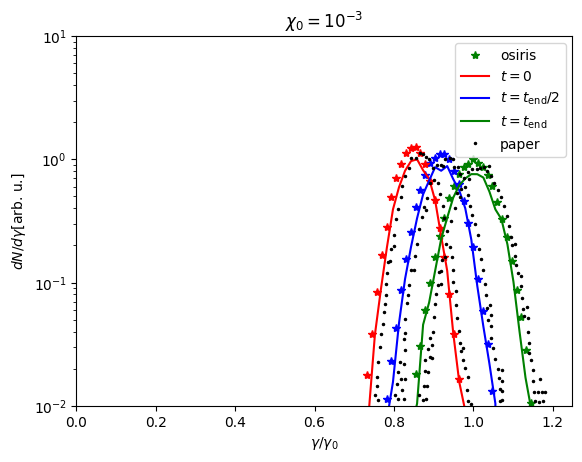

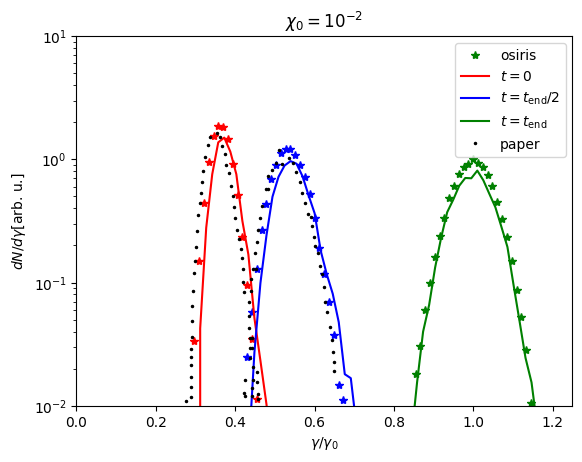

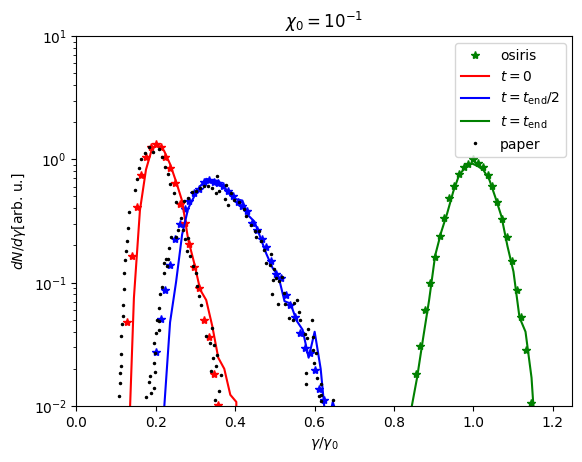

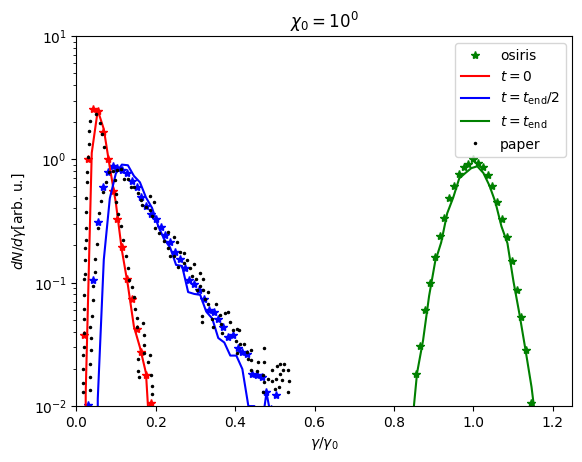

In [6]:
# plot
ytmp0, xtmp = plotOsiris(chiSim='chi1e-3', t=0)
plt.step(xtmp/1800, ytmp0/np.max(ytmp0), '*g', label=r'osiris')
ytmp1, xtmp = plotOsiris(chiSim='chi1e-3', t=1)
plt.step(xtmp/1800, ytmp1/np.max(ytmp0), '*b')
ytmp2, xtmp = plotOsiris(chiSim='chi1e-3', t=2)
plt.step(xtmp/1800, ytmp2/np.max(ytmp0), '*r')
plt.plot(chi3t1x/1800, chi3t1y/np.max(chi3t1y), '-r', label=r'$t=0$' )
plt.plot(chi3t2x/1800, chi3t2y/np.max(chi3t1y), '-b', label=r'$t=t_\mathrm{end}/2$' )
plt.plot(chi3t3x/1800, chi3t3y/np.max(chi3t1y), '-g', label=r'$t=t_\mathrm{end}$' )
# paper
f = open('dataWPD/fig10chi3/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs], 'k.', label=r'paper', markersize=3)
#
plt.xlim([0,1.25])
plt.ylim(np.array([1e-2,1e1]) )
plt.yscale('log')
plt.xlabel(r'$\gamma/\gamma_0$')
plt.ylabel(r'$dN/d\gamma$[arb. u.]')
plt.title(r'$\chi_0=10^{-3}$')
plt.legend()
plt.show()

# plot
ytmp0, xtmp = plotOsiris(chiSim='chi1e-2', t=0)
plt.step(xtmp/1800, ytmp0/np.max(ytmp0), '*g', label=r'osiris')
ytmp1, xtmp = plotOsiris(chiSim='chi1e-2', t=1)
plt.step(xtmp/1800, ytmp1/np.max(ytmp0), '*b')
ytmp2, xtmp = plotOsiris(chiSim='chi1e-2', t=2)
plt.step(xtmp/1800, ytmp2/np.max(ytmp0), '*r')
plt.plot(chi2t1x/1800, chi2t1y/np.max(chi2t1y)*1.5, '-r', label=r'$t=0$' )
plt.plot(chi2t2x/1800, chi2t2y/np.max(chi2t1y)*1.5, '-b', label=r'$t=t_\mathrm{end}/2$' )
plt.plot(chi2t3x/1800, chi2t3y/np.max(chi2t1y)*1.5, '-g', label=r'$t=t_\mathrm{end}$' )
# paper
f = open('dataWPD/fig10chi2/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs], 'k.', label=r'paper', markersize=3)
#
plt.xlim([0,1.25])
plt.ylim(np.array([1e-2,1e1]) )
plt.yscale('log')
plt.xlabel(r'$\gamma/\gamma_0$')
plt.ylabel(r'$dN/d\gamma$[arb. u.]')
plt.title(r'$\chi_0=10^{-2}$')
plt.legend()
plt.show()

# plot
ytmp0, xtmp = plotOsiris(chiSim='chi1e-1', t=0)
plt.step(xtmp/1800, ytmp0/np.max(ytmp0), '*g', label=r'osiris')
ytmp1, xtmp = plotOsiris(chiSim='chi1e-1', t=1)
plt.step(xtmp/1800, ytmp1/np.max(ytmp0), '*b')
ytmp2, xtmp = plotOsiris(chiSim='chi1e-1', t=2)
plt.step(xtmp/1800, ytmp2/np.max(ytmp0), '*r')
plt.plot(chi1t1x/1800, chi1t1y/np.max(chi1t1y)*1.3, '-r', label=r'$t=0$' )
plt.plot(chi1t2x/1800, chi1t2y/np.max(chi1t1y)*1.3, '-b', label=r'$t=t_\mathrm{end}/2$' )
plt.plot(chi1t3x/1800, chi1t3y/np.max(chi1t1y)*1.3, '-g', label=r'$t=t_\mathrm{end}$' )
# paper
f = open('dataWPD/fig10chi1/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs], 'k.', label=r'paper', markersize=3)
#
plt.xlim([0,1.25])
plt.ylim(np.array([1e-2,1e1]) )
plt.yscale('log')
plt.xlabel(r'$\gamma/\gamma_0$')
plt.ylabel(r'$dN/d\gamma$[arb. u.]')
plt.title(r'$\chi_0=10^{-1}$')
plt.legend()
plt.show()

# plot
ytmp0, xtmp = plotOsiris(chiSim='chi1e-0', t=0)
plt.step(xtmp/1800, ytmp0/np.max(ytmp0), '*g', label=r'osiris')
ytmp1, xtmp = plotOsiris(chiSim='chi1e-0', t=1)
plt.step(xtmp/1800, ytmp1/np.max(ytmp0), '*b')
ytmp2, xtmp = plotOsiris(chiSim='chi1e-0', t=2)
plt.step(xtmp/1800, ytmp2/np.max(ytmp0), '*r')
plt.plot(chi0t1x/1800, chi0t1y/np.max(chi0t1y)*2.5, '-r', label=r'$t=0$' )
plt.plot(chi0t2x/1800, chi0t2y/np.max(chi0t1y)*2.5, '-b', label=r'$t=t_\mathrm{end}/2$' )
plt.plot(chi0t3x/1800, chi0t3y/np.max(chi0t1y)*2.5, '-g', label=r'$t=t_\mathrm{end}$' )
# paper
f = open('dataWPD/fig10chi0/wpd.json')
data = json.load(f)
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs], 'k.', label=r'paper', markersize=3)
#
plt.xlim([0,1.25])
plt.ylim(np.array([1e-2,1e1]) )
plt.yscale('log')
plt.xlabel(r'$\gamma/\gamma_0$')
plt.ylabel(r'$dN/d\gamma$[arb. u.]')
plt.title(r'$\chi_0=10^{0}$')
plt.legend()
plt.show()

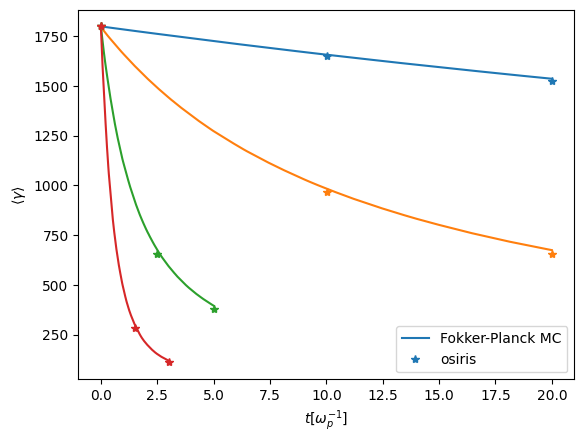

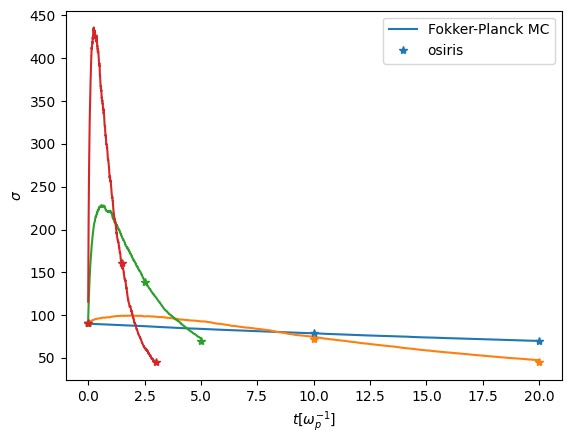

In [7]:
tlst3 = np.linspace(0,20,len(chi3mom1)); tlst2 = np.linspace(0,20,len(chi3mom1)); tlst1 = np.linspace(0,5,len(chi3mom1)); tlst0 = np.linspace(0,3,len(chi3mom1))

plt.plot(tlst3, chi3mom1, label='Fokker-Planck MC')
plt.plot(tlst2, chi2mom1)
plt.plot(tlst1, chi1mom1)
plt.plot(tlst0, chi0mom1)
plt.plot(tlst3[[0,int(len(chi3mom1)/2),-1]], chi3osirismom1, '*', color='tab:blue', label=r'osiris')
plt.plot(tlst2[[0,int(len(chi3mom1)/2),-1]], chi2osirismom1, '*', color='tab:orange')
plt.plot(tlst1[[0,int(len(chi3mom1)/2),-1]], chi1osirismom1, '*', color='tab:green')
plt.plot(tlst0[[0,int(len(chi3mom1)/2),-1]], chi0osirismom1, '*', color='tab:red')
plt.xlabel(r'$t[\omega_p^{-1}]$')
plt.ylabel(r'$\langle \gamma \rangle$')
plt.legend()
plt.show()

plt.plot(tlst3, chi3mom2, label='Fokker-Planck MC')
plt.plot(tlst2, chi2mom2)
plt.plot(tlst1, chi1mom2)
plt.plot(tlst0, chi0mom2)
plt.plot(tlst3[[0,int(len(chi3mom1)/2),-1]], chi3osirismom2, '*', color='tab:blue', label=r'osiris')
plt.plot(tlst2[[0,int(len(chi3mom1)/2),-1]], chi2osirismom2, '*', color='tab:orange')
plt.plot(tlst1[[0,int(len(chi3mom1)/2),-1]], chi1osirismom2, '*', color='tab:green')
plt.plot(tlst0[[0,int(len(chi3mom1)/2),-1]], chi0osirismom2, '*', color='tab:red')
plt.xlabel(r'$t[\omega_p^{-1}]$')
plt.ylabel(r'$\sigma$')
plt.legend()
plt.show()